In [1]:
import time
import serial
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.fft import fft
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



In [2]:
import glob
import os
import pandas as pd

# Procurar arquivos CSV no diretório especificado
csv_files = glob.glob('../data/*.csv')

# Normalizar os caminhos dos arquivos para usar barras '/'
csv_files = [os.path.normpath(file).replace('\\', '/') for file in csv_files]
for file in csv_files:
    print(file)
    

../data/bci_data_correto1.csv
../data/bci_data_correto10.csv
../data/bci_data_correto11.csv
../data/bci_data_correto12.csv
../data/bci_data_correto13.csv
../data/bci_data_correto14.csv
../data/bci_data_correto2.csv
../data/bci_data_correto3.csv
../data/bci_data_correto4.csv
../data/bci_data_correto5.csv
../data/bci_data_correto6.csv
../data/bci_data_correto7.csv
../data/bci_data_correto8.csv
../data/bci_data_correto9.csv


In [3]:
# Parâmetros 
window_size = 1250  # Número de amostras por janela
overlap = 0.25  # Sobreposição entre janelas
cutoff = 40 # Frequência de corte em Hz



X_features = []
y_labels = []
medicoes = 0

# Filtro passa-baixa
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Definir parâmetros do filtro
frequencia_amostragem = 250  # Taxa de amostragem média em Hz (ajustada para EEG típico)


for file in csv_files:
    # leitura do arquivo csv
    data = pd.read_csv(file, sep=';')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    data['VALUE'] = data['VALUE']*(3.3/4098)
    
    print(f'Processando arquivo {file} | {data.shape[0]} amostras\n')
    medicoes += data.shape[0]
    #####################################
    # CRIAR JANELAS
    #####################################

    # Parâmetros
    step_size = int(window_size * (1 - overlap))

    # Lista para armazenar as janelas
    windows = []
    labels = []

    # Criar janelas com sobreposição e atribuir labels
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        
        # Verificar se algum valor na janela tem CONCENTRATION = 1
        if window['CONCENTRATION'].any() == 1:
            labels.append(1)
        else:
            labels.append(0)
            
        windows.append(window)

    # Adicionar as janelas e labels ao array de labels
    y_labels.extend(labels)
    
    #####################################
    # FILTRO EM TODAS JANELAS
    #####################################
    f_windows = []  # Lista para armazenar os DataFrames filtrados

    # Iterar sobre as janelas para aplicar os filtros
    for i, window in enumerate(windows):
        # Extrair dados da janela
        timestamp = np.array(window['TIMESTAMP'])
        value = np.array(window['VALUE'])
        
        # Aplicar filtro passa-baixa
        filtered_value = butter_lowpass_filter(value, cutoff, frequencia_amostragem)
        
        # Criar um DataFrame com os dados filtrados
        filtered_window = pd.DataFrame({
            'TIMESTAMP': timestamp,
            'VALUE': filtered_value,
        })
        
        # Adicionar o DataFrame filtrado à lista
        f_windows.append(filtered_window)
        
    #####################################
    # FFT
    #####################################
    # Inicializar o array para armazenar as características
    ffts = []
    
    # Iterar sobre as janelas
    for window in f_windows:
        # Extrair os valores da primeira janela
        values = window['VALUE'].values - np.mean(window['VALUE'].values)

        # Calcular a taxa de amostragem como o inverso da média das diferenças de tempo
        timestamp_diff = window['TIMESTAMP'].diff().dt.total_seconds()
        sampling_rate = 1 / timestamp_diff[timestamp_diff > 0].mean()

        # Calcular a FFT dos valores
        fft_values = np.abs(fft(values))[:len(values)//2]
        
        # Adicionar a FFT ao array de características
        ffts.append(fft_values)
    
    # Adicionar as características ao array de características
    X_features.extend(ffts)
        
    # print(f'Arquivo {file} processado | {len(ffts)} janelas e {len(labels)} labels\n')
    # print('-----------------------------------\n')

# print total de medicoes separando por . as dezenas
print(f'Total de medições: {medicoes:,}\n')
print('-----------------------------------\n')

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f'Número total de janelas: {len(X_features)}')
print('-----------------------------------\n')

print(f'Número de janelas com CONCENTRATION = 1: {np.sum(y_labels)}')
print(f'Número de janelas com CONCENTRATION = 0: {len(y_labels) - np.sum(y_labels)}')

Processando arquivo ../data/bci_data_correto1.csv | 185001 amostras

Processando arquivo ../data/bci_data_correto10.csv | 153601 amostras

Processando arquivo ../data/bci_data_correto11.csv | 141624 amostras

Processando arquivo ../data/bci_data_correto12.csv | 154303 amostras

Processando arquivo ../data/bci_data_correto13.csv | 151061 amostras

Processando arquivo ../data/bci_data_correto14.csv | 66421 amostras

Processando arquivo ../data/bci_data_correto2.csv | 185492 amostras

Processando arquivo ../data/bci_data_correto3.csv | 174240 amostras

Processando arquivo ../data/bci_data_correto4.csv | 155924 amostras

Processando arquivo ../data/bci_data_correto5.csv | 164941 amostras

Processando arquivo ../data/bci_data_correto6.csv | 153751 amostras

Processando arquivo ../data/bci_data_correto7.csv | 108662 amostras

Processando arquivo ../data/bci_data_correto8.csv | 155521 amostras

Processando arquivo ../data/bci_data_correto9.csv | 166140 amostras

Total de medições: 2,116,682



----

PROCESSAMENTO 2


In [4]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
import pywt

# Parâmetros
window_size = 2952  # Número de amostras por janela
overlap = 0.57  # Sobreposição entre janelas
cutoff = 51  # Frequência de corte em Hz
frequencia_amostragem = 250  # Taxa de amostragem média em Hz (ajustada para EEG típico)

X_features = []
y_labels = []
medicoes = 0

from scipy.interpolate import interp1d
def pad_or_interpolate(array, target_length):
    if len(array) < target_length:
        # Padding
        return np.pad(array, (0, target_length - len(array)), 'constant', constant_values=0)
    elif len(array) > target_length:
        # Interpolation
        x = np.arange(len(array))
        f = interp1d(x, array, kind='linear', fill_value='extrapolate')
        x_new = np.linspace(0, len(array)-1, target_length)
        return f(x_new)
    else:
        return array
    
# Filtro passa-baixa
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Função para calcular a potência nas bandas de frequência usando FFT
def band_power_fft(fft_values, freqs, band):
    # Filtra as frequências que estão dentro da banda desejada
    band_power = np.trapezoid(fft_values[(freqs >= band[0]) & (freqs <= band[1])], freqs[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

# Função para extrair features estatísticas
def extract_stat_features(data):
    mean = np.mean(data)
    variance = np.var(data)
    skewness = pd.Series(data).skew()
    kurtosis = pd.Series(data).kurtosis()
    return mean, variance, skewness, kurtosis

# Função para aplicar a transformada wavelet
def extract_wavelet_features(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet)
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.extend([np.mean(coeff), np.var(coeff), np.min(coeff), np.max(coeff)])
    return wavelet_features

for file in csv_files:
    # Leitura do arquivo CSV
    data = pd.read_csv(file, sep=';')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    data['VALUE'] = data['VALUE'] * (3.3 / 4098)

    print(f'Processando arquivo {file} | {data.shape[0]:,} amostras')
    medicoes += data.shape[0]

    # CRIAR JANELAS
    step_size = int(window_size * (1 - overlap))
    windows = []
    labels = []

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]

        # Verificar se algum valor na janela tem CONCENTRATION = 1
        if window['CONCENTRATION'].any() == 1:
            labels.append(1)
        else:
            labels.append(0)

        windows.append(window)

    y_labels.extend(labels)

    # FILTRO EM TODAS JANELAS
    f_windows = []
    for i, window in enumerate(windows):
        timestamp = np.array(window['TIMESTAMP'])
        value = np.array(window['VALUE'])

        # Aplicar filtro passa-baixa
        filtered_value = butter_lowpass_filter(value, cutoff, frequencia_amostragem)
        filtered_window = pd.DataFrame({'TIMESTAMP': timestamp, 'VALUE': filtered_value})
        f_windows.append(filtered_window)

    # Extração de Features
    for window in f_windows:
        values = window['VALUE'].values - np.mean(window['VALUE'].values)

        # Taxa de amostragem
        timestamp_diff = window['TIMESTAMP'].diff().dt.total_seconds()
        sampling_rate = 1 / timestamp_diff[timestamp_diff > 0].mean()

        # FFT
        fft_values = np.abs(fft(values))[:len(values)//2]
        freqs = np.fft.fftfreq(len(values), d=1/sampling_rate)[:len(values)//2]
        fft_values_filtered = fft_values[freqs <= (cutoff + 5)]
        
        fixed_length = 348
        fft_values_filtered = pad_or_interpolate(fft_values_filtered, fixed_length)
        # print(f'Comprimento FFT Filtrada: {len(fft_values_filtered)}')

        # Potência nas bandas de frequência usando FFT
        delta_power = band_power_fft(fft_values, freqs, [0.5, 4])
        theta_power = band_power_fft(fft_values, freqs, [4, 8])
        alpha_power = band_power_fft(fft_values, freqs, [8, 13])
        beta_power = band_power_fft(fft_values, freqs, [13, 30])

        # Features estatísticas
        mean, variance, skewness, kurtosis = extract_stat_features(values)

        # Transformada Wavelet
        wavelet_features = extract_wavelet_features(values)

        # Combinar todas as features
        # features = list(fft_values) + [delta_power, theta_power, alpha_power, beta_power, mean, variance, skewness, kurtosis] + wavelet_features
        # features =  list(fft_values) + [delta_power, theta_power, alpha_power, beta_power] #MLP Classifier	0.757911	0.780645	0.640212	0.703488
        features =  list(fft_values_filtered) + list(wavelet_features)

        X_features.append(features)

# Conversão para arrays numpy
X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f'Total de medições: {medicoes:,}\n')
print('-----------------------------------')

print(f'Número total de janelas: {len(X_features)}')
print('-----------------------------------')

print(f'Número de janelas com CONCENTRATION = 1: {np.sum(y_labels)}')
print(f'Número de janelas com CONCENTRATION = 0: {len(y_labels) - np.sum(y_labels)}')


Processando arquivo ../data/bci_data_correto1.csv | 185,001 amostras
Processando arquivo ../data/bci_data_correto10.csv | 153,601 amostras
Processando arquivo ../data/bci_data_correto11.csv | 141,624 amostras
Processando arquivo ../data/bci_data_correto12.csv | 154,303 amostras
Processando arquivo ../data/bci_data_correto13.csv | 151,061 amostras
Processando arquivo ../data/bci_data_correto14.csv | 66,421 amostras
Processando arquivo ../data/bci_data_correto2.csv | 185,492 amostras
Processando arquivo ../data/bci_data_correto3.csv | 174,240 amostras
Processando arquivo ../data/bci_data_correto4.csv | 155,924 amostras
Processando arquivo ../data/bci_data_correto5.csv | 164,941 amostras
Processando arquivo ../data/bci_data_correto6.csv | 153,751 amostras
Processando arquivo ../data/bci_data_correto7.csv | 108,662 amostras
Processando arquivo ../data/bci_data_correto8.csv | 155,521 amostras
Processando arquivo ../data/bci_data_correto9.csv | 166,140 amostras
Total de medições: 2,116,682



TREINAMENTO

In [5]:
# # nomralize X_features
# scaler = StandardScaler()
# X_features = scaler.fit_transform(X_features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=74)

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")

Tamanho treino: (1149, 384)
Tamanho teste: (493, 384)


	Classifier: LinearSVC
	Accuracy: 0.6795131845841785
	Precision: 0.7351778656126482
	Recall: 0.6714801444043321
	F1-score: 0.7018867924528301


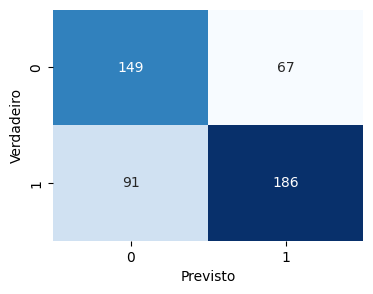



	Classifier: Logistic Regression
	Accuracy: 0.6835699797160243
	Precision: 0.7391304347826086
	Recall: 0.6750902527075813
	F1-score: 0.7056603773584905


C:\Users\I749044\AppData\Local\Temp\ipykernel_1472\4137450559.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})], ignore_index=True)
c:\Users\I749044\Documents\neuroTests\neuroTechnic\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

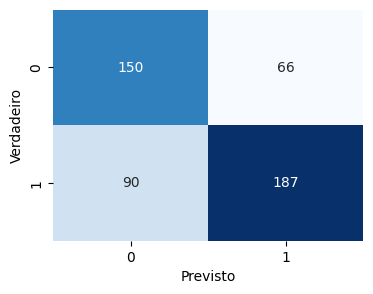



	Classifier: Random Forest
	Accuracy: 0.7728194726166329
	Precision: 0.7894736842105263
	Recall: 0.8122743682310469
	F1-score: 0.800711743772242


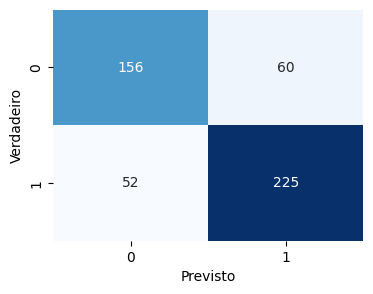



	Classifier: K-Nearest Neighbors
	Accuracy: 0.7241379310344828
	Precision: 0.7786561264822134
	Recall: 0.7111913357400722
	F1-score: 0.7433962264150943


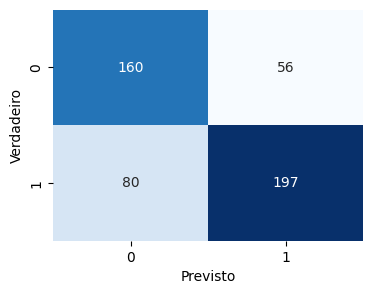



	Classifier: Gradient Boosting
	Accuracy: 0.8052738336713996
	Precision: 0.8389513108614233
	Recall: 0.8086642599277978
	F1-score: 0.8235294117647058


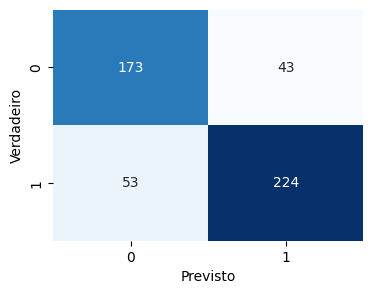



	Classifier: Decision Tree
	Accuracy: 0.6734279918864098
	Precision: 0.7148148148148148
	Recall: 0.6967509025270758
	F1-score: 0.7056672760511883


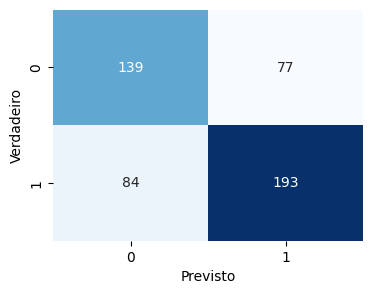



	Classifier: Gaussian Naive Bayes
	Accuracy: 0.665314401622718
	Precision: 0.8255813953488372
	Recall: 0.5126353790613718
	F1-score: 0.6325167037861915


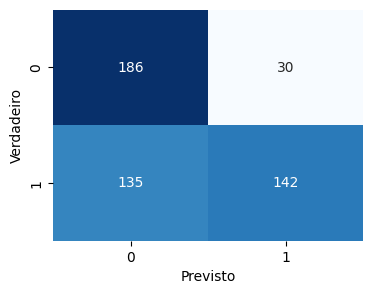



	Classifier: Support Vector Classifier
	Accuracy: 0.7383367139959433
	Precision: 0.7642857142857142
	Recall: 0.7725631768953068
	F1-score: 0.7684021543985637


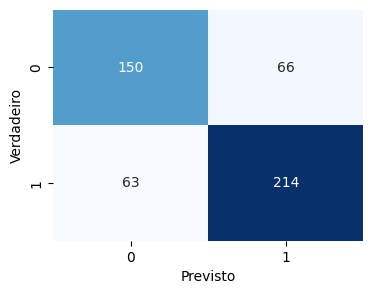

c:\Users\I749044\Documents\neuroTests\neuroTechnic\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	Classifier: AdaBoost Classifier
	Accuracy: 0.768762677484787
	Precision: 0.8075471698113208
	Recall: 0.7725631768953068
	F1-score: 0.7896678966789668


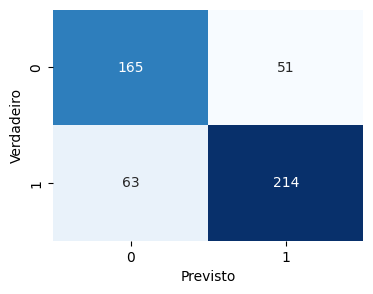



	Classifier: Linear Discriminant Analysis
	Accuracy: 0.6896551724137931
	Precision: 0.7440944881889764
	Recall: 0.6823104693140795
	F1-score: 0.711864406779661


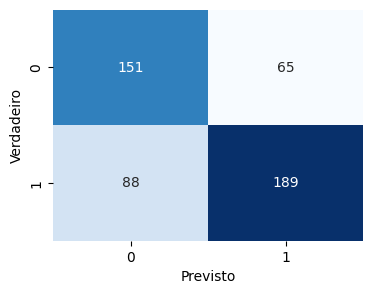



	Classifier: MLP Classifier
	Accuracy: 0.691683569979716
	Precision: 0.8048780487804879
	Recall: 0.5956678700361011
	F1-score: 0.6846473029045643


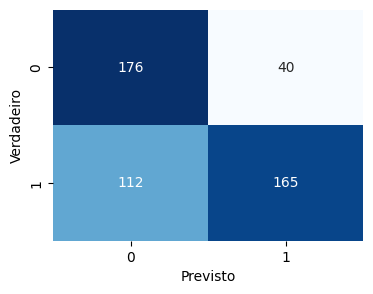

,Model,Accuracy,Precision,Recall,F1
4,Gradient Boosting,0.805274,0.838951,0.808664,0.823529
2,Random Forest,0.772819,0.789474,0.812274,0.800712
8,AdaBoost Classifier,0.768763,0.807547,0.772563,0.789668
7,Support Vector Classifier,0.738337,0.764286,0.772563,0.768402
3,K-Nearest Neighbors,0.724138,0.778656,0.711191,0.743396
10,MLP Classifier,0.691684,0.804878,0.595668,0.684647
9,Linear Discriminant Analysis,0.689655,0.744094,0.682310,0.711864
1,Logistic Regression,0.683570,0.739130,0.675090,0.705660
0,LinearSVC,0.679513,0.735178,0.671480,0.701887
5,Decision Tree,0.673428,0.714815,0.696751,0.705667


In [9]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Classifier': SVC(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(24, 8, 6, 4), max_iter=1000, early_stopping=True )
}


results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Loop sobre cada classificador
for name, clf in classifiers.items():
    # Treinar o classificador
    clf.fit(X_train, y_train)
    
    # Prever os rótulos do conjunto de teste
    y_pred = clf.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir métricas
    print(f"\tClassifier: {name}")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tPrecision: {precision}")
    print(f"\tRecall: {recall}")
    print(f"\tF1-score: {f1}")
    
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()
    # plt.title(f'Matriz de confusão - {name}')

    print("\n")

    #create a dataframe with the results linke model name, accuracy, precision, recall and f1
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})], ignore_index=True)

# print the results ordered by f1 score and accuracy
results = results.sort_values(by='Accuracy', ascending=False)
results


In [7]:
# model = classifiers["MLP Classifier"]

# import pickle

# # Após treinar o modelo:
# with open('mlp.pkl', 'wb') as f:
#     pickle.dump(model, f)
